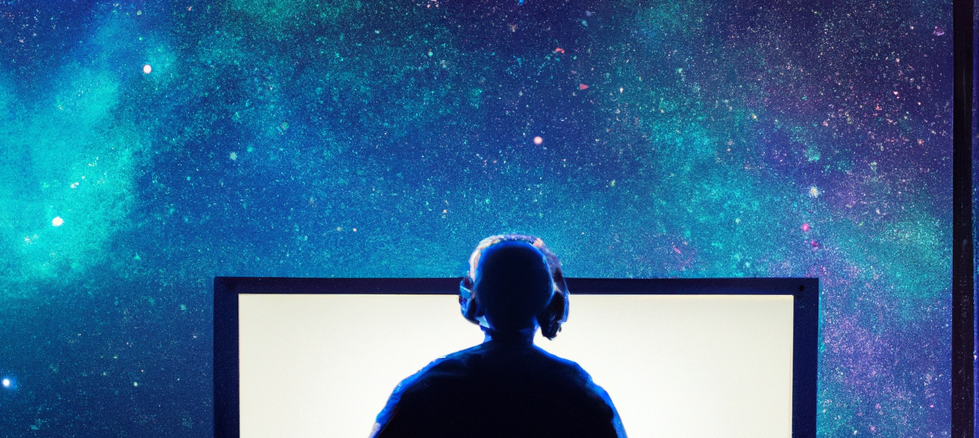

# Quantifying Market Efficiency: A Python & Machine Learning Approach Across Asset Classes #

#### By Scott Morgan


<Something about highlightlighting Bloomberg API, the package. Not to put down BQUANT>

In the vast expanse of the financial universe, every asset class pulses with its own unique heartbeat, charting stories molded by economic dynamics, investor sentiments, geopolitical influences, and a plethora of factors that dictate global finance. From the frenetic pace of US equities, to the steady income of corporate bonds and the vast landscapes of foregin stock markets - each weaves tales of synchronicity, divergence, opportunity, and chaos.

For the majority of my career, I have worked closely with portfolio managers and analysts on both the fixed income and equity sides of the isle. Conversations in research meetings, risk management reviews and marketing pitches consistently revolved around trading relative value within a firm's capital structure to seize alpha. It was a dance of navigating from high yield bonds at the top, right down to the equity, suggesting potential inefficiencies along the way. But where was the quantitative proof? Over time, this lingering curiosity has grown into a broader quest: Do market efficiencies truly differ across major asset classes? And if so, could machine learning help us unearth, quantify, and then exploit these inefficiencies?

While the corridors of academia are lined with theses on this subject, my aim is to combine the analytical prowess of machine learning with my industry insights to unravel this enigma. This will not be a perfect study - I take assumptions, there will be oversights, but this is a starting point rather than a conclusive statement. Feedback, as always, is a gift.

In the following sections we delve into historical return profiles, intricacies of market efficiency, its layers, and its significance in the sphere of active management. Leveraging various python libraries and the Bloomberg Professional Service, we'll dissect asset classes, zero in on company-specific instances, and navigate the potentials of machine learning-driven investment strategies. 

Remember that these views are personal, and as history has often demonstrated, past performance seldom guarantees future results.

## The Layers of Market Efficiency:
The Efficient Market Hypothesis (EMH) has long been a subject of debate and analysis. Among the most notable contributions is Burton Malkiel's work, particularly his proposition of the stock market as a 'random walk', suggesting that future stock prices are independent of past prices.

- **Weak Form:**  Past price and volume information cannot predict future prices. A key metric to gauge this is auto-correlation.

- **Semi-Strong Form:** All publicly available information is reflected in asset prices. Key metrics include reaction times to earnings announcements, macroeconomic news, and other publicly available data sources.

- **Strong Form:** All information, public and private, is reflected in asset prices. Metrics here would involve scrutinizing insider trading data and major institutional transactions.

In [1]:
##Install# pip install blpapi --index-url=https://bcms.bloomberg.com/pip/simple/

from xbbg import blp
import pandas as pd
import os
from scipy.stats import skew, kurtosis, bartlett
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import joblib
import shap
import plotly.graph_objects as go
from IPython.display import display, HTML
from xgboost import XGBClassifier
import ta

# Suppress warnings
pd.set_option('mode.chained_assignment', None)

plt.rcParams["font.family"] = "Arial"

# Define the file paths and tickers
tickers = ['RIY Index','RTY Index', 'C0A0 Index','H0A0 Index','SPBDAL Index', 'MXEA Index', 'MXEF Index','EMUSTRUU Index', 'SFFRNEWS Index']
readable_names = ['US Large Cap Equities','US Small Cap Equities','US Investment Grade Bonds', 'US High Yield Bonds', 'US Bank Loans', 'Developed Country Equities', 'Emerging Market Equities','Emerging Market Debt', 'Sentiment Score']

index_prices_path = "data/index_prices.csv"
index_returns_path = "data/index_returns.csv"

def fetch_data(tickers, start_date, end_date):
    return blp.bdh(tickers=tickers, flds=['Px_Last'], start_date=start_date, end_date=end_date)

date_string = "4/2/2007"
date_format = "%m/%d/%Y"
start_date = datetime.strptime(date_string, date_format)
end_date = datetime.today()

index_prices_exists = os.path.exists(index_prices_path)
index_returns_exists = os.path.exists(index_returns_path)

if not index_prices_exists or not index_returns_exists:
    print("Fetching data from Bloomberg...")
    data = fetch_data(tickers, start_date, end_date)

    # Processing Index Prices
    if not index_prices_exists:
        print("Processing and saving Index Prices...")
        index_data_raw = data.copy()
        index_data_raw.columns = readable_names
        index_prices = index_data_raw
        index_prices.index = pd.to_datetime(index_prices.index)
        index_prices = index_prices[index_prices.index.weekday < 5]
        index_prices.dropna(inplace=True)
        index_prices.to_csv(index_prices_path)
    
    # Processing Index Returns
    if not index_returns_exists:
        print("Processing and saving Index Returns...")
        index_returns_raw = index_prices.drop(columns=['Sentiment Score'])
        index_returns_raw = index_returns_raw.pct_change().dropna()
        threshold = len(index_returns_raw.columns) - 2
        index_returns = index_returns_raw.dropna(thresh=threshold)
        index_returns.index = pd.to_datetime(index_returns.index)
        index_returns = index_returns[index_returns.index.weekday < 5]
        index_returns.dropna(inplace=True)
        index_returns.to_csv(index_returns_path)
else:
    # Load CSV files if they already exist
    index_prices = pd.read_csv(index_prices_path, index_col=0, parse_dates=True)
    index_returns = pd.read_csv(index_returns_path, index_col=0, parse_dates=True)
    print("Data loaded from existing CSV files.")

print("Process completed.")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Data loaded from existing CSV files.
Process completed.


## The Landscape of Asset Returns ##
Before delving into the intricacies of market efficiency, it's essential to set a foundation by understanding the landscape of asset returns over approximately 20 years of daily data. Delving into the return distributions of these asset classes, we see distinct patterns hinting at potential inefficiencies.

For starters, the kurtosis value for **US Bank Loans** of 93.23 is staggering, indicating extreme fluctuations in returns, far more than what a normal distribution might suggest. Coupled with its extremely negative skewness, it points towards pronounced left-tailed events, suggesting the asset class might be prone to significant downturns. **US High Yield Bonds and Emerging Market Debt** are not far behind, with their substantial kurtosis values of 26.07 and 27.62 respectively, and pronounced negative skews, implying potential downside risks. On the contrast, asset classes like **US Large Cap Equities, US Small Cap Equities, and Emerging Market Equities** have milder skewness and kurtosis values and thus resemble a more normal distributions.

However, every number has its story, and these statistics act as our preamble as we prepare to dive deeper into the realms of market efficiency.

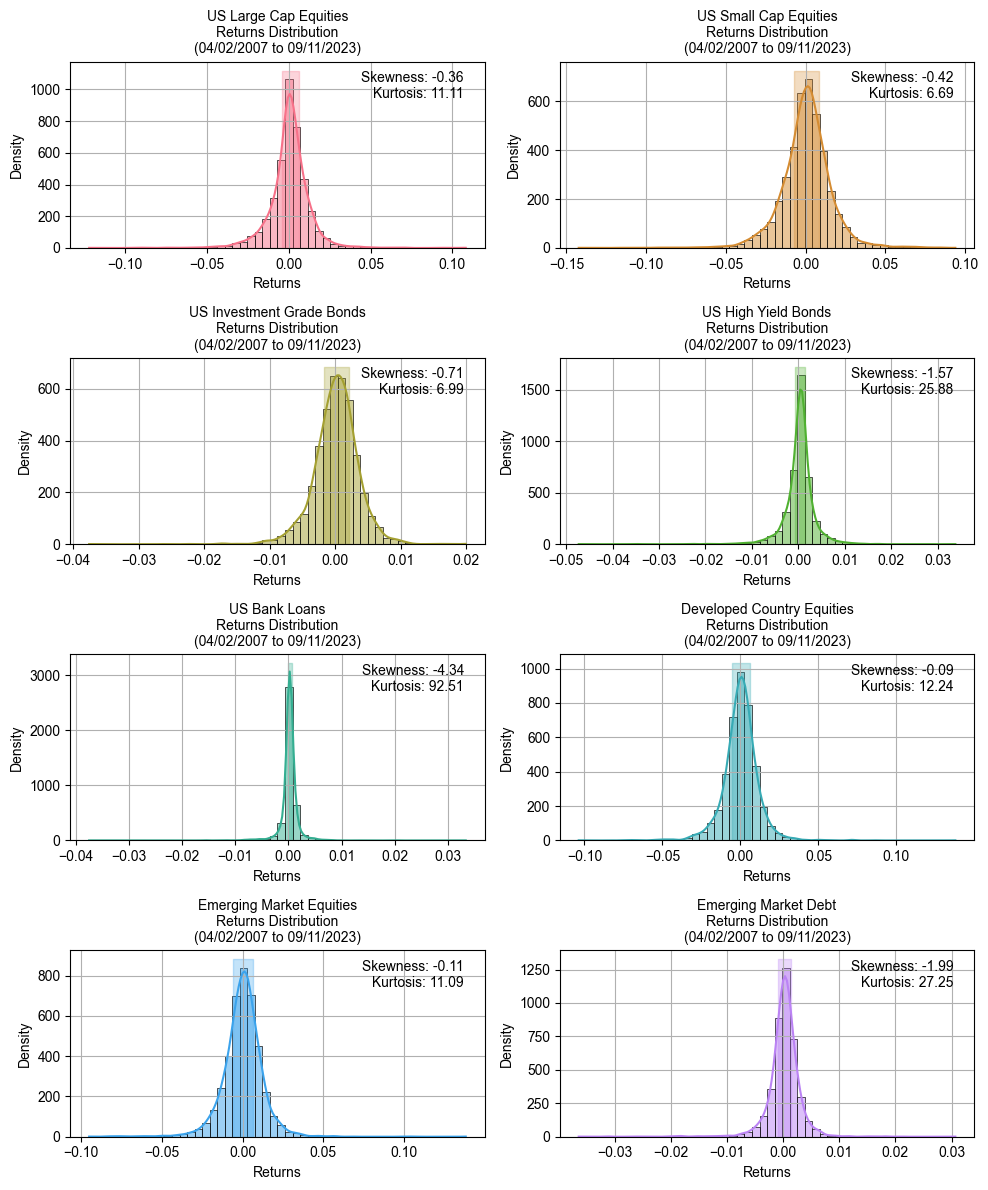

In [2]:
from scipy.stats import skew, kurtosis

# Colors from specified color palette
colors = sns.color_palette("husl", len(readable_names))

# Calculate the number of rows and columns for subplots
num_rows = 4
num_cols = 2

# Skewness and Kurtosis calculations
numeric_columns = index_returns.select_dtypes(include='number').columns
numeric_data = index_returns[numeric_columns]

# Skewness and Kurtosis calculations
skewness_values = numeric_data.skew()
kurtosis_values = numeric_data.kurt()
skew_kurt_df = pd.DataFrame({
    'Skewness': skewness_values,
    'Kurtosis': kurtosis_values
})

# Create subplots with smaller figsize
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

for idx, (name, row) in enumerate(skew_kurt_df.iterrows()):
    row_idx = idx // num_cols
    col_idx = idx % num_cols

    ax = axs[row_idx, col_idx]
    sns.histplot(index_returns[name], bins=50, kde=True, ax=ax, color=colors[idx])

    # Calculate the 25th and 75th percentiles for the overlay rectangle
    q25, q75 = np.percentile(index_returns[name], [25, 75])

    # Add a semi-transparent rectangle overlay
    ax.fill_between([q25, q75], ax.get_ylim()[0], ax.get_ylim()[1], color=colors[idx], alpha=0.3)

    # Format the start_date and end_date for the title
    formatted_start_date = start_date.strftime('%m/%d/%Y')
    formatted_end_date = end_date.strftime('%m/%d/%Y')
    
    # Create a multi-line title
    title = f"{name}\nReturns Distribution\n({formatted_start_date} to {formatted_end_date})"
    ax.set_title(title, fontsize=10)  # Adjust title font size
    ax.set_xlabel("Returns")
    ax.set_ylabel("Density")  # Change y-axis label to Density
    ax.grid(True)

    # Add Skewness and Kurtosis values in upper right corner
    skewness = row['Skewness']
    kurtosis = row['Kurtosis']
    ax.text(0.95, 0.95, f"Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}",
            transform=ax.transAxes, va='top', ha='right', fontsize=10, color='black')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# print(skew_kurt_df)


## Unraveling Drawdown Dynamics: An Efficiency Paradox? ##
Drawing insights from the largest drawdowns of various asset classes offers a nuanced perspective on market efficiency. **US High Yield Bonds and US Bank Loans**, for instance, display noticeable signs of potential inefficiency in their return distributions. Intriguingly, they also register the smallest drawdowns, which might seem counterintuitive at first. Smaller drawdowns often indicate a more stable asset class, but when combined with other inefficiencies, they raise questions. Could inefficiencies, in some cases, play a stabilizing role, or are there other underlying factors at play? These findings certainly set the stage for more detailed investigations.

From an investment strategy standpoint, the stability of these assets, combined with their potential inefficiencies, makes them attractive candidates. It hints at possible opportunities to capitalize on mispricings while also enjoying a relatively stable performance. The following sections will delve deeper into designing investment strategies around these insights.

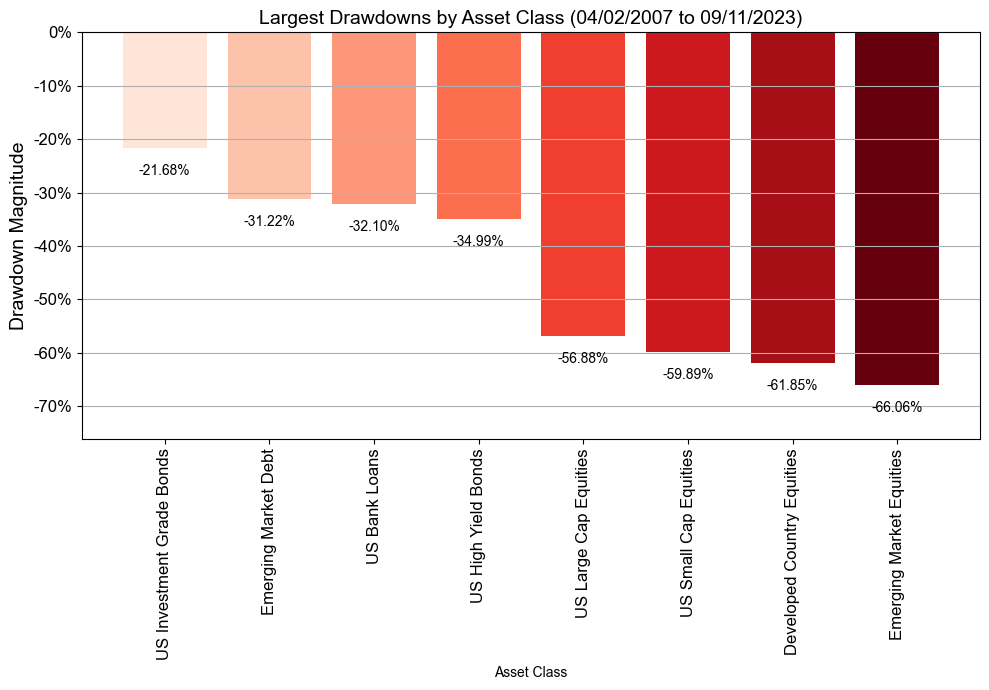

In [3]:
# Compute the running cumulative returns
cum_returns = (1 + index_returns).cumprod()

# Compute the running maximum
running_max = cum_returns.cummax()

# Compute the drawdowns
drawdowns = (cum_returns - running_max) / running_max

# Find the largest drawdown for each asset class
largest_drawdowns = drawdowns.min()

# Get the minimum y-axis value
min_y_value = largest_drawdowns.min() - 0.1

# Visualization
plt.figure(figsize=(10, 7))

# Define the color gradient based on the values
colors = plt.cm.Reds(np.linspace(0.1, 1, len(largest_drawdowns)))

sorted_indices = largest_drawdowns.argsort()[::-1]  # Sorting values for better visualization
sorted_drawdowns = largest_drawdowns.iloc[sorted_indices]

bars = plt.bar(sorted_drawdowns.index, sorted_drawdowns.values, color=colors)

# Set title and labels with increased font size
title = f"Largest Drawdowns by Asset Class ({formatted_start_date} to {formatted_end_date})"

plt.title(title, fontsize=14)  # Adjust title font size
plt.ylabel('Drawdown Magnitude', fontsize=14)
plt.xlabel('Asset Class', fontsize=10)
plt.grid(axis='y')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Set y-axis limits
plt.ylim(min_y_value, None)

# Format the y-axis labels as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))

# Highlighting the largest drawdown value
for i, v in enumerate(sorted_drawdowns):
    # Check if the drawdown is too large (for example, smaller than -15%)
    if v < -0.15:
        plt.text(i, v - 0.03, f"{v:.2%}", ha='center', va='top', fontweight='regular', fontsize=10, color='black')
    else:
        plt.text(i, v + 0.02, f"{v:.2%}", ha='center', va='bottom', fontweight='regular', fontsize=10, color='black')

plt.tight_layout()
plt.show()


## Correlation Analsysis
Peeling back another layer of the financial onion, correlation analysis offers insights into the relationship between asset class returns for a given time frame. With nearly 16 years of daily data to draw from, the co-movement patterns emerge with clarity. Most strikingly, **US Large Cap Equities and US Small Cap Equities** boast a high correlation of 0.917, illustrating their synchronous behavior in the financial markets. On the flip side, **US Investment Grade Bonds** show a mild negative correlation with both **Large and Small Cap Equities**, hinting at potential diversification benefits when constructing portfolios. A deeper dive into the correlation between **US High Yield Bonds and US Bank Loans** reveals a strong positive relationship, echoing a similar risk and return profile. Meanwhile, **Emerging Market Equities and Developed Country Equities** also move in tandem, as evidenced by their correlation coefficient of 0.782. 

Such correlation patterns are not only crucial for asset allocation decisions but also lay the groundwork for understanding the nuances of market efficiency and potential anomalies that might arise in interconnected markets.

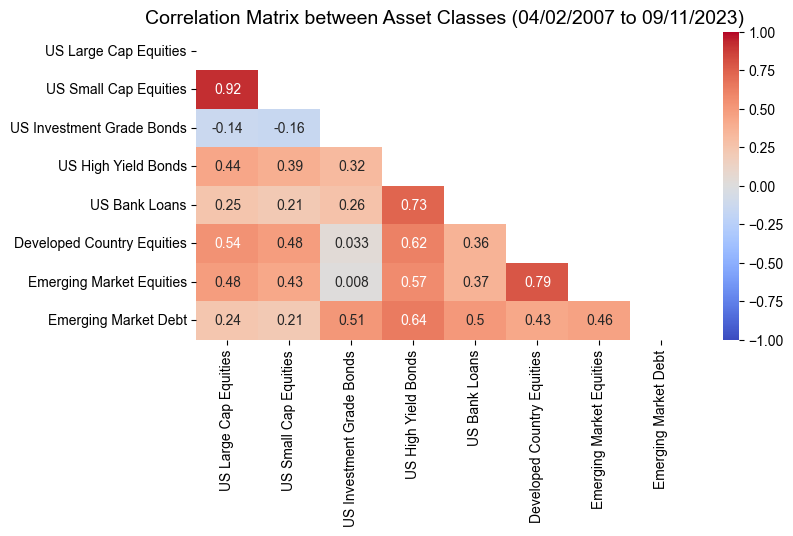

In [4]:
corr= index_returns.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

plt.figure(figsize=(8,4))

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, cmap='coolwarm', vmin=-1, vmax=1)
title = f"Correlation Matrix between Asset Classes ({formatted_start_date} to {formatted_end_date})"
plt.title(title, fontsize=14)
plt.show()

# print(corr)


## Empirical Analysis Across Asset Classes ##

### Weak Form Efficiency and Autocorrelation

The weak form of the Efficient Market Hypothesis (EMH) posits that current asset prices fully incorporate all available historical information, primarily past prices. Hence, investors shouldn't be able to consistently earn above-average returns using historical data alone. In this context, if an asset class's returns display significant autocorrelation (i.e. if points are above the blue shaded regions in below graphs), it could indicate that past returns have some predictive power over future returns. This would challenge the notion of weak form efficiency, as it implies that there's some momentum or mean reversion in returns that could potentially be exploited

#### Methodology

The Autocorrelation Function (ACF) plots directly below reveal insights into the predictability and structure of financial time series, potentially hinting at market efficiency.

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


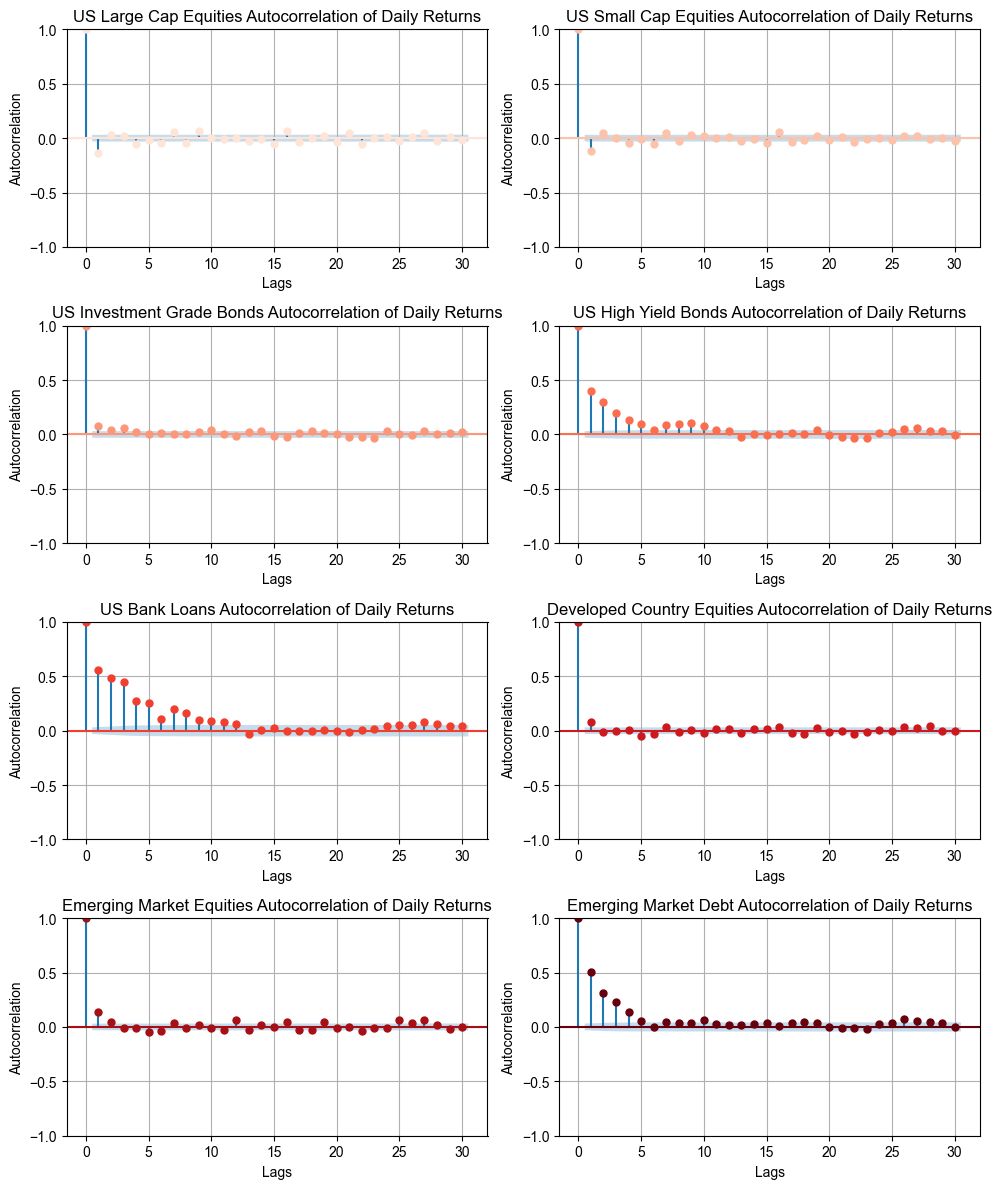

In [5]:
# Exclude 'Sentiment Score' from the list
readable_names = [name for name in readable_names if name != 'Sentiment Score']

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

# Plot autocorrelation for each index
for idx, name in enumerate(readable_names):
    ax = axs[idx//2, idx%2]
    
    # Plotting autocorrelation
    sm.graphics.tsa.plot_acf(index_returns[name].dropna(), lags=30, title=f"{name} Autocorrelation of Daily Returns", ax=ax, color=colors[idx])
    
    # Ensuring markers have the same color as lines
    line = ax.lines[0]  # This should get the line from the ACF plot
    line.set_markerfacecolor(colors[idx])
    line.set_markeredgecolor(colors[idx])
    
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)

plt.tight_layout()
plt.show()


#### Weak Form Findings
Diving into the autocorrelation of asset class returns offers intriguing insights. **US Large Cap and Small Cap Equities** both show initial mean reversion tendencies with their pronounced negative autocorrelation at the first lag. **US Investment Grade Bonds** differ, hinting at potential momentum with positive initial lags. The momentum is also evident in **US High Yield Bonds and US Bank Loans**, where the persistence of positive autocorrelation across several lags suggests potential inefficiencies or return predictability. Meanwhile, **Developed Country Equities** and **Emerging Market Equities** present a mixed interplay of market dynamics, revealing potential inefficiencies in their patterns. **Emerging Market Debt**, much like the **High Yield Bonds**, also suggests momentum, especially in the initial lags. 

***These findings suggest that past returns of US High Yield Bonds, US Bank Loans and Emerging Market Debt during the time period potentially explain future returns; thus inefficiencies could exist in these markets. The remaining asset classes behave as a random walk and are potentially weakly efficient.***



### Semi-Strong Form Efficiency and Using Machine Learning to Test Market Reaction ###

The semi-strong form of market efficiency asserts that asset prices adjust rapidly to all publicly available information (green line below) and are unpredictable (i.e. a random walk), so neither technical analysis nor fundamental analysis can consistently achieve superior returns. If markets are semi-stong inefficient, prices will adjust gradually and should be more predictable.

#### Methodology

To examine the semi-strong form of the EMH, I used an XGBoost classifier—a very popular gradient boosting framework - because of its versatility and transparency. The essence of our test: If the models, trained on historical technical indicators, can consistently predict post-event returns with an accuracy significantly greater than 50%, it implies that the asset class doesn't rapidly incorporate event-related data, challenging the semi-strong form of EMH. Conversely, an accuracy close to or below 50% would suggest that post-event returns are seemingly random after accounting for known event information, supporting the semi-strong form.

The dataset was split into 'event' and 'non-event' periods. Models were trained for each respective asset class (8 total) on the 'non-event' days and put to the test on the 'event' days, mimicking a real-world scenario where investors aim to exploit new public data. Below is an interactive summary of the periods. The 'event days' are a 30 day window following the announcement of a event (see reference table below chart for expect starts). 

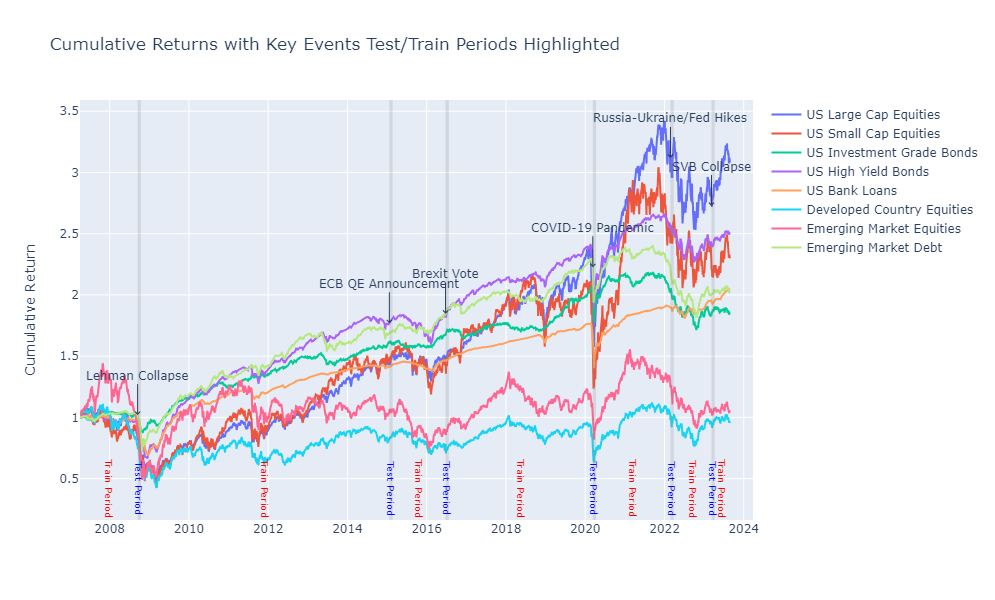

In [6]:
# Assuming `returns` is a DataFrame
cumulative_returns = (1 + index_returns).cumprod()

events_dates = pd.to_datetime(['9/15/2008', '1/22/2015', '6/23/2016', '3/11/2020', '2/25/2022', '3/10/2023'])
events_labels = ['Lehman Collapse', 'ECB QE Announcement', 'Brexit Vote', 'COVID-19 Pandemic', 'Russia-Ukraine/Fed Hikes', 'SVB Collapse']

# Define test periods based on events
test_periods = [(date, date + pd.Timedelta(days=30)) for date in events_dates]

# Create a new figure
fig = go.Figure()

# Plot cumulative returns for each asset
for asset in index_returns.columns:
    fig.add_trace(go.Scatter(x=cumulative_returns.index, y=cumulative_returns[asset], mode='lines', name=asset))

# Highlight events with shaded regions and label them
for date, label in zip(events_dates, events_labels):
    # Shading 30 days post-event
    fig.add_vrect(x0=date, x1=date + pd.Timedelta(days=30), fillcolor="gray", opacity=0.2, line_width=0)
    # Annotating the event
    fig.add_annotation(x=date, y=max(cumulative_returns.loc[date]), text=label, showarrow=True, arrowhead=4, ax=0, ay=-40)

# Annotate Test Periods
for start, end in test_periods:
    mid_date = start + (end - start) / 2
    closest_date = cumulative_returns.index[np.argmin(np.abs(cumulative_returns.index - mid_date))]
    fig.add_annotation(
        x=closest_date, 
        y=cumulative_returns.min().min(),  # Set to minimum cumulative return for bottom
        text="Test Period", 
        showarrow=False, 
        font=dict(color="blue", size=10),
        textangle=90
    )

# Annotate Train Periods
train_start = cumulative_returns.index[0]
for start, _ in test_periods:
    mid_date = train_start + (start - train_start) / 2
    closest_date = cumulative_returns.index[np.argmin(np.abs(cumulative_returns.index - mid_date))]
    fig.add_annotation(
        x=closest_date, 
        y=cumulative_returns.min().min(),  # Set to minimum cumulative return for bottom
        text="Train Period", 
        showarrow=False, 
        font=dict(color="red", size=10),
        textangle=90
    )
    train_start = start + pd.Timedelta(days=30)

# Annotate last Train Period if necessary
if train_start < cumulative_returns.index[-1]:
    mid_date = train_start + (cumulative_returns.index[-1] - train_start) / 2
    closest_date = cumulative_returns.index[np.argmin(np.abs(cumulative_returns.index - mid_date))]
    fig.add_annotation(
        x=closest_date, 
        y=cumulative_returns.min().min(),  # Set to minimum cumulative return for bottom
        text="Train Period", 
        showarrow=False, 
        font=dict(color="red", size=10),
        textangle=90
    )

fig.update_layout(title='Cumulative Returns with Key Events Test/Train Periods Highlighted', yaxis_title='Cumulative Return', height=600)
fig.show()

# Define the data for the events
data = {
    'Event': ['Lehman Collapse', 'ECB QE Announcement', 'Brexit Vote', 'COVID-19 Pandemic', 'Russia-Ukraine/Fed Hikes', 'SVB Collapse'],
    'Event Date': ['9/15/2008', '1/22/2015', '6/23/2016', '3/11/2020', '2/25/2022', '3/10/2023']
}

# Convert the 'Event Date' column to datetime format
data['Event Date'] = pd.to_datetime(data['Event Date'])

# Create a DataFrame from the data
df_events = pd.DataFrame(data)

# Create a centered HTML string for the table
centered_table = f"<center>{df_events.to_html(index=False)}</center>"

# Display the centered HTML table using the display function
display(HTML(centered_table))


 I constructed a number of trailing technical features from the historical price data of the asset classes. These are the independent variables. For the targets, or dependent variables, I used the next day (t+1) returns of the respective indexes. Below are the descriptions of each.
 
<u>**Dependent Variables**</u>
- **SMA (Simple Moving Average):** The average price of an n asset over a specific number of days. It's "simple" because each day's price has equal weight.

- **EMA (Exponential Moving Average):** Similar to SMA, but it gives more weight to recent prices. This responsiveness means EMA reacts more quickly to price changes than SMA.

- **RSI (Relative Strength Index):** A momentum oscillator ranging from 0 to 100, indicating the speed and change of price movements. Typically, an RSI above 70 suggests an asset might be overbought, while an RSI below 30 suggests it might be oversold.

- **MACD (Moving Average Convergence Divergence):** A trend-following momentum indicator, represented by the difference between a short-term EMA and a long-term EMA. MACD signals are typically derived from its crossovers with its signal line (an EMA of the MACD itself).

<u>**Targets/Dependent Variables**</u>
- **Next Day Returns:** The target variables are the next day (t+1) returns of the respective indexes. I chose to use future returns versus prices because predicting returns is more feasible; returns capture relative changes and inherent volatility, providing clearer insight into an asset's dynamic behavior. Next, I transformed the returns into binary variables: '1' for a positive return and '0' for a negative return. By converting continuous next-day returns into binary indicators, we focus on predicting directional trends rather than exact magnitudes, simplifying the modeling process and reducing noise.

<u>**Evaluation**</u>

We evaluate the models at T+5 days, T+30 days, T+60 days and T+90 days. By testing the model's performance across varying time periods after an event, I am examining the speed at which new information is incorporated into prices across different asset classes. If a model consistently generates accurate predictions greater than 50% long after an event, it could indicate inefficiencies in the market or that the market is taking longer to assimilate the new information, which would challenge the semi-strong form of the EMH.

In evaluating the models across different time periods, the primary metric of interest remains the F1 Score. This metric becomes especially significant in contexts like financial trading where both types of errors – false positives (erroneously buying) and false negatives (missing out on a genuine buying opportunity) – are financially penalizing. The F1 Score serves as an optimal metric because it is the harmonic mean of precision and recall, ensuring that a model not only provides trustworthy positive predictions (signifying high precision) but also efficiently identifies the majority of genuine positive opportunities (indicating high recall). 

While we have multiple metrics at our disposal, the dynamic nature of financial markets necessitates the exploration of models across varied time frames. This is crucial as different periods might unveil diverse patterns or anomalies. By identifying the top-performing model across the most relevant time frame for our strong form tests, we're better positioned to harness potential market efficiencies or pinpoint areas of exploitability.

In [8]:
import os
import pickle

asset_columns = ['US Large Cap Equities', 'US Small Cap Equities',
                     'US Investment Grade Bonds', 'US High Yield Bonds', 'US Bank Loans',
                     'Developed Country Equities', 'Emerging Market Equities',
                     'Emerging Market Debt']
    

def generate_lagged_returns_and_targets(df):
   
    lagged_returns = index_returns.shift(-1)
    lagged_returns.dropna(inplace=True)
    # lagged_returns.columns = [f"Next_Day_TRR_{col}" for col in lagged_returns.columns]
    lagged_returns.columns = [f"{col}" for col in lagged_returns.columns]
    
    for column in lagged_returns.columns:
        lagged_returns[column] = (lagged_returns[column] > 0).astype(int)
    
    return lagged_returns

lagged_targets = generate_lagged_returns_and_targets(index_returns)


def MACD(series, short_window, long_window, signal_window):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.rolling(window=signal_window).mean()
    return macd_line, signal_line

def generate_technical_indicators(df):
    indicator_dataframes = []

    for column in df.columns:
        # Skip 'Sentiment Score' for now as you instructed
        if column == 'Sentiment Score':
            continue

        sma_30 = ta.trend.SMAIndicator(close=df[column], window=30).sma_indicator()
        sma_60 = ta.trend.SMAIndicator(close=df[column], window=60).sma_indicator()

        ema_30 = ta.trend.EMAIndicator(close=df[column], window=30).ema_indicator()
        ema_60 = ta.trend.EMAIndicator(close=df[column], window=60).ema_indicator()


        rsi_14 = ta.momentum.RSIIndicator(close=df[column], window=14).rsi()
        macd, macdsignal = MACD(df[column], 12, 26, 9)  # modified the unpacking

        indicators = pd.concat([
            sma_30.rename(f"{column}_SMA_30"),
            sma_60.rename(f"{column}_SMA_60"),
            ema_30.rename(f"{column}_EMA_30"),
            ema_60.rename(f"{column}_EMA_60"),
            rsi_14.rename(f"{column}_RSI_14"),
            macd.rename(f"{column}_MACD"),
            macdsignal.rename(f"{column}_MACD_Signal")
        ], axis=1)

        indicator_dataframes.append(indicators)

    combined_indicators = pd.concat(indicator_dataframes, axis=1)
    combined_indicators = combined_indicators.dropna()

    return combined_indicators

technical_features = generate_technical_indicators(index_prices)
combined_data = pd.concat([technical_features, lagged_targets], axis=1)
combined_data.dropna(inplace=True) # Drop NaN value

# Event Data Preparation

data = {
    'Event': ['Lehman Collapse','ECB QE Announcement', 'Brexit Vote', 'COVID-19 Pandemic','Russia-Ukraine/Fed Hikes','SVB Collapse'],
    'Event Date': ['9/15/2008', '1/22/2015', '6/23/2016', '3/11/2020','2/25/2022','3/10/2023']
}

df_events = pd.DataFrame(data)
df_events['Event Date'] = pd.to_datetime(df_events['Event Date'])

def get_test_dates(df, pre_days, post_days_list):
    test_dates_dict = {}
    for post_days in post_days_list:
        test_dates = []
        for date in df['Event Date']:
            start_date = date - timedelta(days=pre_days)
            end_date = date + timedelta(days=post_days)
            test_dates.extend(pd.date_range(start=start_date, end=end_date).tolist())
        test_dates_dict[post_days] = test_dates
    return test_dates_dict

# List of days after event
days_after_event = [5, 30, 60, 90]

# List of asset classes (you might need to adjust this according to your dataset)
asset_classes = [
    'US Large Cap Equities', 
    'US Small Cap Equities', 
    'US Investment Grade Bonds', 
    'US High Yield Bonds', 
    'US Bank Loans', 
    'Developed Country Equities', 
    'Emerging Market Equities', 
    'Emerging Market Debt'
]


# Get test dates for all intervals
test_dates_dict = get_test_dates(df_events, 0, days_after_event)

# Dictionary to store evaluation metrics for each day interval
all_evaluation_metrics = {}

# Ensure the models directory exists
if not os.path.exists('./models/'):
    os.makedirs('./models/')

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}    

def train_initial_models(X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    print("Training initial models...")
    
    # DataFrame to store feature importances for all assets
    feature_importances_df = pd.DataFrame()
    
    results = {}
    for asset in X_train_dict:
        X_train = X_train_dict[asset]
        y_train = y_train_dict[asset]
        
        X_test = X_test_dict[asset]
        y_test = y_test_dict[asset]
        
        model = XGBClassifier(objective='binary:logistic', tree_method='gpu_hist')
        model.fit(X_train, y_train)
        
        # Extract feature importances
        feature_importances = model.feature_importances_
        temp_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': feature_importances,
            'Asset': asset  # Adding the asset name to differentiate
        })
        # feature_importances_df = feature_importances_df.append(temp_df)
        feature_importances_df = pd.concat([feature_importances_df, temp_df], ignore_index=True)
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        results[asset] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_pred_proba)
        }



#Loop through each day interval
for days in days_after_event:
    test_dates = test_dates_dict[days]
    for asset_class in asset_classes:
        
        # Filter columns related to the current asset class
        relevant_columns = [col for col in combined_data.columns if col.startswith(asset_class)]
        
        asset_data = combined_data[relevant_columns]
        
        # Assuming the target variable for each asset class is simply its name (e.g., 'US Large Cap Equities')
        if asset_class not in asset_data.columns:
            continue
        
        train = asset_data[~asset_data.index.isin(test_dates)]
        test = asset_data[asset_data.index.isin(test_dates)]

        X_train_dict[asset_class] = train.drop(asset_class, axis=1)
        y_train_dict[asset_class] = train[asset_class]
        
        X_test_dict[asset_class] = test.drop(asset_class, axis=1)
        y_test_dict[asset_class] = test[asset_class]

        # Step 2: Train the models using the dictionaries
        evaluation_metrics, model = train_initial_models(X_train_dict, y_train_dict, X_test_dict, y_test_dict)
        all_evaluation_metrics[f"{asset_class}_{days} days"] = evaluation_metrics

        # Save the trained model
        with open(f'./models/{asset_class}_model_{days}_days.pkl', 'wb') as f:
            pickle.dump(model, f)

# Aggregate all evaluation metrics into a single dataframe
staging_evaluation_df = pd.concat({k: pd.DataFrame(v).T for k, v in all_evaluation_metrics.items()}, axis=0)

# Use the unstack method to pivot the DataFrame
pivot_df = staging_evaluation_df.unstack(level=0)

# The above line will pivot the 'Time Period' level (which appears to be level 0) to columns

# If you want to remove the top-level column (F1 Score) to have a cleaner DataFrame, you can do:
pivot_df.columns = pivot_df.columns.get_level_values(1)

# Sort the columns for better organization (if needed)
ordered_columns = ['5 days', '30 days', '60 days', '90 days']
final_evaluation_df = pivot_df[ordered_columns]


NameError: name 'train_initial_models' is not defined

#### Semi-Strong Findings

The results suggest a nuanced understanding of market efficiency across different time intervals. 

- For US Large Cap Equities, the F1 scores progressively increased from 0.64 over 5 days to 0.56 over 90 days. While this indicates a trend towards randomness and supports the semi-strong form of the Efficient Market Hypothesis (EMH), there are fluctuations that warrant closer examination. On the other hand, US Small Cap Equities exhibited scores ranging from 0.45 to 0.52, showcasing more pronounced volatility in shorter time frames, which stabilizes over longer durations.

- US Investment Grade Bonds, with F1 scores ranging from 0.43 to 0.55, exhibit moderate efficiencies over the tested time intervals. However, **US High Yield Bonds and US Bank Loans, displaying scores like 0.62 and 0.75, respectively, over a 90-day period, reinforce the earlier observation of stronger pattern recognition capabilities. These scores, being considerably above the 0.5 mark, suggest potential inefficiencies in these markets. It implies that there's room for investors or traders to potentially capitalize on certain patterns or information.**

- Developed Country Equities, Emerging Market Equities, and Emerging Market Debt display scores that hover around the 0.5 to 0.6 range, suggesting a degree of randomness but with some hints of pattern recognition, especially in the longer time frames. This could be indicative of semi-strong market efficiency, but the door remains open for further analysis and scrutiny.

To summarize, while some asset classes seem to align more closely with the semi-strong form of the EMH, others, especially US High Yield Bonds and US Bank Loans, indicate potential market inefficiencies that might be exploitable.

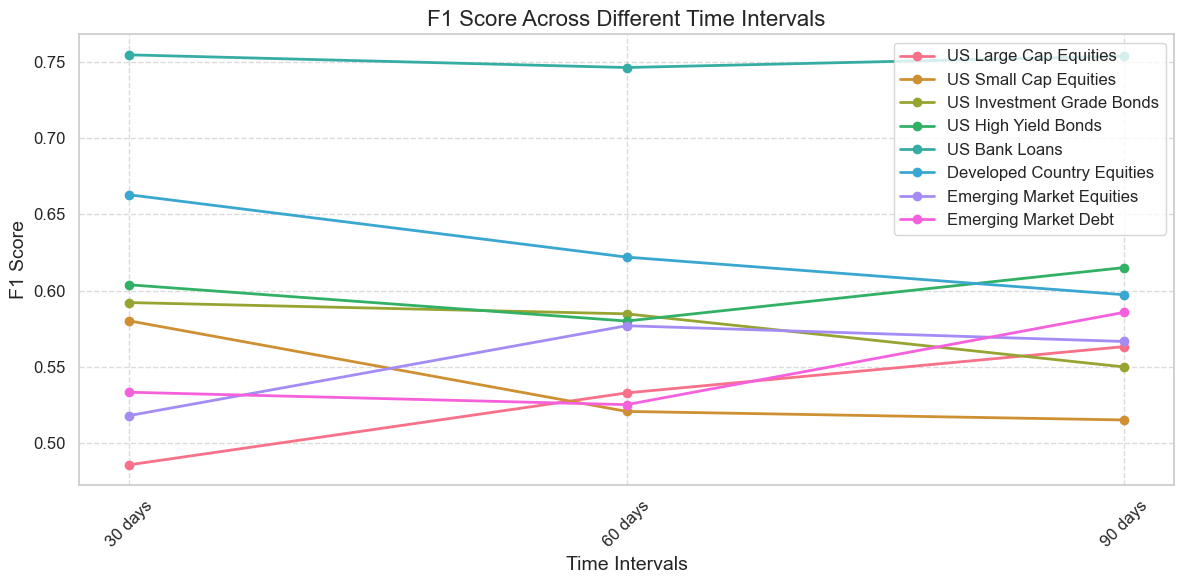

In [81]:
def highlight_f1(row):
    return ['background-color: yellow' if col == 'F1 Score' else '' for col in row.index]

styled_evaluation_df = (final_evaluation_df.style
                        .apply(highlight_f1)
                        .format("{:.2f}")
                        .set_caption("<b style='font-size: 16px'>F1 Metrics for XGBoost Across Different Time Intervals</b>")
                        .set_table_styles({
                            'F1 Score': [{'selector': '',
                                          'props': [('color', 'black'),
                                                    ('font-weight', 'bold')]}]
                       
                        }))
display(styled_evaluation_df)

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your final_evaluation_df DataFrame defined

# Set a seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors for each category
colors = sns.color_palette("husl", n_colors=len(final_evaluation_df))

# Iterate through each row (category) in final_evaluation_df
for i, (index, row) in enumerate(final_evaluation_df.iterrows()):
    # Plot a smooth line for each category with the corresponding color
    plt.plot(row.index[1:], row.values[1:], marker='o', label=index, color=colors[i], linewidth=2)

# Customize the plot
plt.title("F1 Score Across Different Time Intervals", fontsize=16)
plt.xlabel("Time Intervals", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

A few caveats to bear in mind:

- **1** These results do not provide definitive proof regarding the EMH but rather offer insights into varying efficiency levels across asset classes.

- **2** The models weren't subjected to hyperparameter tuning, which could potentially enhance their performance and provideclearer insights.
 
Next, I will leverage transfer learning to test strong form efficiency, capitalizing on the top performing model (in this case, US Bank Loans, given its high F1 score) and applying it to other assets. This would test the hypothesis of whether patterns recognized in one asset class can be translated and exploited in others, further challenging the tenets of the EMH.

### Strong Form Efficiency & Transfer Learning

The strong form of market efficiency posits that all information, public and private, is instantly reflected in asset prices. Testing this hypothesis requires examining whether models trained on one set of data (say, public data) can generalize and make predictions on another set (potentially mimicking private information scenarios). Transfer learning is a natural fit for this kind of evaluation.

<center>
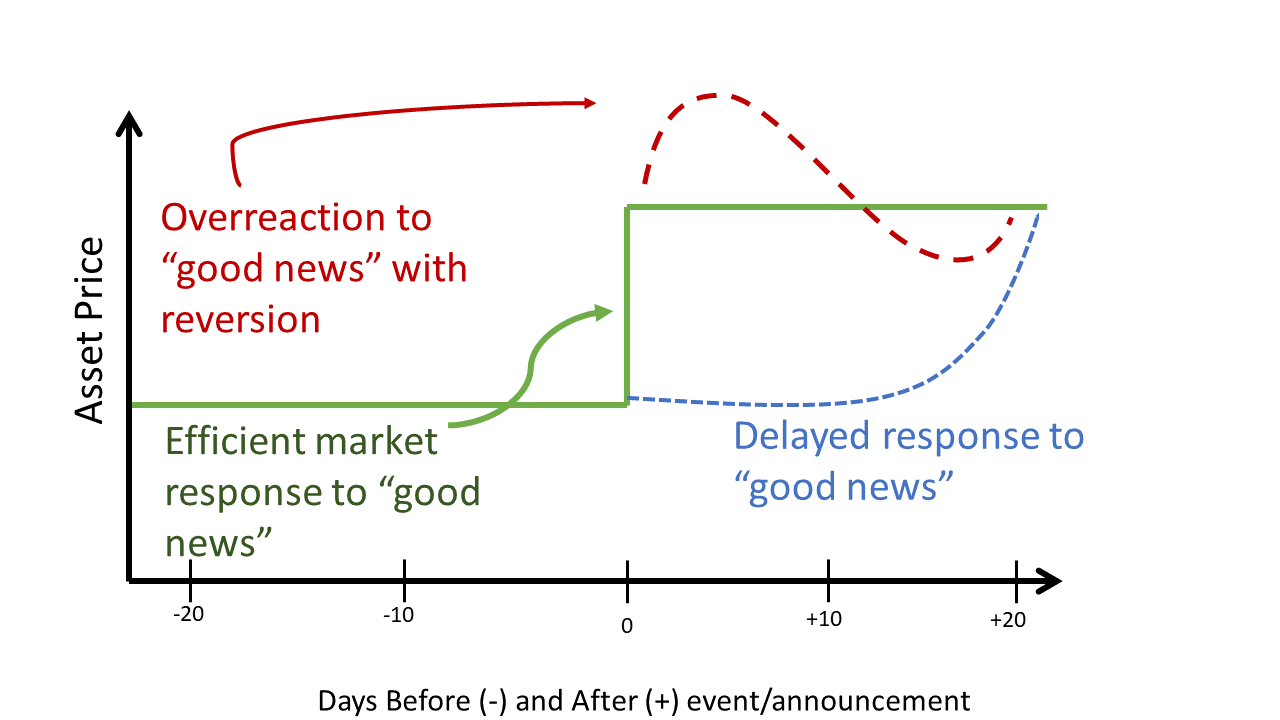
</center>

#### Methodology

Historically a powerhouse technique in deep learning, especially in the domain of image and language processing, transfer learning allows models trained on one dataset to apply their knowledge to a different, though related, dataset. In our context, this means leveraging the patterns and intricacies learned from one asset class, such as bank loans, to potentially enhance the model's predictive capability on another, like equities or bonds. The underlying assumption is that there might be hidden, overarching market dynamics or patterns that are universal across different asset classes.

The choice of using transfer learning is multifaceted. Not only does it provide an opportunity to harness the potential cross-asset predictive power, but it also challenges the very core of the strong form market efficiency. If our models, armed with transfer learning, can consistently outperform the market, it might suggest that there are inefficiencies, or at least patterns, that even sophisticated market participants haven't fully grasped.

I initially turned to the XGBoost algorithm, famed for its precision and adaptability. Yet, the intricate temporal dynamics and complex non-linearities inherent in financial data exposed its limitations. Financial markets, with their multifaceted interactions and time-sensitive structures, demand models that can capture depth and complexity. Enter Keras deep learning models. These models, equipped with capabilities to automatically discern crucial features, adeptly handle sequential data, and intricately model inter-variable relationships, emerged as a more suitable choice. This shift from XGBoost to a Keras-based approach underscores the criticality of aligning the modeling tool with the complexities of the task, especially in the enigmatic realm of finance. 

So in order to complete this series of tests, I had to retrain our XGBoost models using Keras. The results are below and are similar to our original results, with US Leveraged Loans outperforming and will therefore be used as our base model. Transfer learning comes into play when we adapt the US Leveraged Loan model to other asset classes. If this adapted model also performs well on other asset classes, it might suggest that certain information is consistently not being incorporated across multiple asset classes.

In [ ]:
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Assuming the models are saved in the './models/' directory
base_model_path = './models/US Bank Loans_model.pkl'
base_model = joblib.load(base_model_path)

def evaluate_on_base_model(base_model, X_test_dict, y_test_dict):
    evaluation_results = {}
    feature_importances_df = pd.DataFrame()  # DataFrame to store feature importances

    for asset, X_test in X_test_dict.items():
        # Skip the base model's asset class itself
        if asset == "US Bank Loans":
            continue

        y_test = y_test_dict[asset]

        # Standardize variable names to fit base model input
        rename_dict = {col: col.replace(asset, "US Bank Loans") for col in X_test.columns}
        X_test_renamed = X_test.rename(columns=rename_dict)

        y_pred = base_model.predict(X_test_renamed)
        y_pred_proba = base_model.predict_proba(X_test_renamed)[:, 1]

        evaluation_results[asset] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=1),  # This sets precision to 1 when there are no predicted positives.
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_pred_proba)
        }

        # Extract feature importances for the asset and store in the DataFrame
        temp_df = pd.DataFrame({
            'Feature': X_test_renamed.columns,
            'Importance': base_model.feature_importances_,
            'Asset': asset  # Adding the asset name for differentiation
        })
        feature_importances_df = pd.concat([feature_importances_df, temp_df], ignore_index=True)

    return evaluation_results, feature_importances_df

transfer_learning_results, importances_df = evaluate_on_base_model(base_model, X_test_dict, y_test_dict)

# Convert results dictionary into a DataFrame
transfer_learning_df = pd.DataFrame(transfer_learning_results).T

# Display the Evaluation Results DataFrame
print(transfer_learning_df)

# Display the Feature Importances DataFrame
print(importances_df)



## Evaluation Metrics

US High Yield Bonds has the highest accuracy, F1 score, and ROC AUC among all asset classes. This suggests that the model performs best when predicting this asset class. All the asset classes have Accuracy and ROC AUC scores slightly above 0.5 or below, indicating the models are not performing much better than a random guess. The Precision is just above 0.5 for most asset classes, meaning slightly more than half of the positive predictions are actually correct. The F1 scores are slightly higher than the accuracy in most cases, suggesting that the harmonic balance between precision and recall is somewhat better than raw accuracy for these predictions.

## Feature Importance

If we look across all asset classes, "US Bank Loans_RSI_14" consistently has the highest importance score (~0.213). This suggests that the RSI_14 (Relative Strength Index for 14 days) of US Bank Loans is the most influential feature in predicting the given asset classes.
Other features like "US Bank Loans_SMA_30", "US Bank Loans_EMA_60", etc., have importance scores that vary but are generally lower than RSI_14. This means they are less influential in the model's predictions compared to RSI_14. The importance values for the same features are consistent across different asset classes. This suggests that the model sees the same relative importances for these features regardless of which asset class it's predicting.

The model's predictive performance across asset classes is mediocre at best, given the scores are not significantly better than random guessing. Among the features, RSI_14 is the most important for making predictions. Further refinement and perhaps feature engineering might be necessary to improve the model's performance.

## Neural Networks

In [ ]:
pip install tensorflow-gpu==2.5.0


In [1]:
!pip install tensorflow-gpu keras


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [44 lines of output]
  Traceback (most recent call last):
    File "C:\ProgramData\anaconda3\envs\blpapi\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
      parsed = _parse_requirement(requirement_string)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\ProgramData\anaconda3\envs\blpapi\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
      return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\ProgramData\anaconda3\envs\blpapi\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
      url, specifier, marker = _parse_requirement_details(tokenizer)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\ProgramData\anaco

In [ ]:
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import h5py

def generate_lagged_returns_and_targets(df):
   
    lagged_returns = index_returns.shift(-1)
    lagged_returns.dropna(inplace=True)
    lagged_returns.columns = [f"{col}" for col in lagged_returns.columns]
    
    for column in lagged_returns.columns:
        lagged_returns[column] = (lagged_returns[column] > 0).astype(int)
    
    return lagged_returns

lagged_targets = generate_lagged_returns_and_targets(index_returns)



def MACD(series, short_window, long_window, signal_window):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.rolling(window=signal_window).mean()
    return macd_line, signal_line

def generate_technical_indicators(df):
    indicator_dataframes = []

    for column in df.columns:
        # Skip 'Sentiment Score' for now as you instructed
        if column == 'Sentiment Score':
            continue

        sma_30 = ta.trend.SMAIndicator(close=df[column], window=30).sma_indicator()
        sma_60 = ta.trend.SMAIndicator(close=df[column], window=60).sma_indicator()

        ema_30 = ta.trend.EMAIndicator(close=df[column], window=30).ema_indicator()
        ema_60 = ta.trend.EMAIndicator(close=df[column], window=60).ema_indicator()


        rsi_14 = ta.momentum.RSIIndicator(close=df[column], window=14).rsi()
        macd, macdsignal = MACD(df[column], 12, 26, 9)  # modified the unpacking

        indicators = pd.concat([
            sma_30.rename(f"{column}_SMA_30"),
            sma_60.rename(f"{column}_SMA_60"),
            ema_30.rename(f"{column}_EMA_30"),
            ema_60.rename(f"{column}_EMA_60"),
            rsi_14.rename(f"{column}_RSI_14"),
            macd.rename(f"{column}_MACD"),
            macdsignal.rename(f"{column}_MACD_Signal")
        ], axis=1)

        indicator_dataframes.append(indicators)

    combined_indicators = pd.concat(indicator_dataframes, axis=1)
    combined_indicators = combined_indicators.dropna()

    return combined_indicators

technical_features = generate_technical_indicators(index_prices)
combined_data = pd.concat([technical_features, lagged_targets], axis=1)
combined_data.dropna(inplace=True)

data = {
    'Event': ['Lehman Collapse','ECB QE Announcement', 'Brexit Vote', 'COVID-19 Pandemic','Russia-Ukraine/Fed Hikes','SVB Collapse'],
    'Event Date': ['9/15/2008', '1/22/2015', '6/23/2016', '3/11/2020','2/25/2022','3/10/2023']
}

df_events = pd.DataFrame(data)
df_events['Event Date'] = pd.to_datetime(df_events['Event Date'])

def get_test_dates(df, pre_days, post_days):
    test_dates = []
    for date in df['Event Date']:
        start_date = date - timedelta(days=pre_days)
        end_date = date + timedelta(days=post_days)
        test_dates.extend(pd.date_range(start=start_date, end=end_date).tolist())
    return test_dates

test_dates = get_test_dates(df_events, 0, 100)
combined_data = combined_data.drop(combined_data.filter(regex='Test').columns, axis=1)

train = combined_data[~combined_data.index.isin(test_dates)]
test = combined_data[combined_data.index.isin(test_dates)]

def prepare_data_for_ml(dataframe):
    print("Data preparation started...")
    
    asset_columns = ['US Large Cap Equities', 'US Small Cap Equities',
                     'US Investment Grade Bonds', 'US High Yield Bonds', 'US Bank Loans',
                     'Developed Country Equities', 'Emerging Market Equities',
                     'Emerging Market Debt']
    
    X_dict, y_dict = {}, {}
    
    for asset_name in asset_columns:
        feature_columns = [ 
            f"{asset_name}_SMA_30",
            f"{asset_name}_SMA_60",
            f"{asset_name}_EMA_30",
            f"{asset_name}_EMA_60",
            f"{asset_name}_RSI_14",
            f"{asset_name}_MACD",
            f"{asset_name}_MACD_Signal"]

        X_dict[asset_name] = dataframe[feature_columns]
        y_dict[asset_name] = dataframe[asset_name]
    
    print("Data preparation completed!")
    return X_dict, y_dict

X_train_dict, y_train_dict = prepare_data_for_ml(train)
X_test_dict, y_test_dict = prepare_data_for_ml(test)

def train_initial_models(X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    print("Training initial models...")
    
    results = {}
    for asset in X_train_dict:
        X_train = X_train_dict[asset]
        y_train = y_train_dict[asset]
        
        X_test = X_test_dict[asset]
        y_test = y_test_dict[asset]
        
        # Standardizing the data
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
                
        # Define the Keras model
        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
        
        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
        
        # Predict
        y_pred_proba = model.predict(X_test).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        results[asset] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_pred_proba)
        }
        
        # Save each model to the models folder
        # model.save(f'./models/{asset}_model.h5')
        model.save(f'./models/{asset}_model.keras')
    
    print("Initial models trained!")
    return results

evaluation_metrics = train_initial_models(X_train_dict, y_train_dict, X_test_dict, y_test_dict)

# Convert the evaluation_metrics dictionary into a DataFrame
evaluation_df = pd.DataFrame(evaluation_metrics).T

# Display the DataFrame
print(evaluation_df)


In [ ]:
from keras.models import load_model

# 1. Load the Pre-trained Model
base_model = load_model('./models/US Bank Loans_model.keras')

# 2. Fine-tuning (Optional)
# Here's an example of freezing the first two layers
for layer in base_model.layers[:2]:
    layer.trainable = False

# A function to adapt and evaluate models using transfer learning
def transfer_and_evaluate(asset):
    X_train = X_train_dict[asset]
    y_train = y_train_dict[asset]
    X_test = X_test_dict[asset]
    y_test = y_test_dict[asset]
    
    # Standardize data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fine-tuning
    model = Sequential(base_model.layers[:-1])  # Exclude last layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    asset_results = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    return asset_results

# 3. Evaluate on New Data
transfer_results = {}
asset_columns = ['US Large Cap Equities', 'US Small Cap Equities',
                 'US Investment Grade Bonds', 'US High Yield Bonds', 
                 'Developed Country Equities', 'Emerging Market Equities',
                 'Emerging Market Debt']

for asset in asset_columns:
    transfer_results[asset] = transfer_and_evaluate(asset)

transfer_evaluation_df = pd.DataFrame(transfer_results).T
print(transfer_evaluation_df)


Given that some bank loan companies are private and might possess material non-public information, the use of data from this asset class could mean the model is tapping into information patterns not fully available or understood by the broader market. If transfer learning models consistently and significantly outperform the market by leveraging this data, it would suggest the potential presence of inefficiencies in the market's pricing of public information, even if not a direct contradiction of the strong form of the EMH. However, it's essential to approach such conclusions with caution. Above-average performance might be due to overfitting, specific market conditions, or other nuances. Furthermore, while back-tested results can be promising, real-world trading, with its associated costs and complexities, can present a different picture.

## Company-specific Instances
Zoom into specific examples to showcase discrepancies or efficiencies within an individual company's capital structure.

When drilling down, it's essential to select companies that have both actively traded equities and bonds. Here are some suggestions:

***Apple Inc.***: Known for issuing bonds despite having a huge cash reserve. Its equity and bonds could respond differently to product launches or other news.

***Microsoft Corporation***: Another tech giant with both active equities and bonds.

***AT&T Inc.***: A company with a significant debt load, providing opportunities to analyze both equity and debt.

***Amazon Inc.***: Given its dominance and wide array of business activities, news and events could trigger varied responses in its capital structure.

***Walmart Inc.***: A retail giant, its equity and debt dynamics could be influenced by economic cycles, consumer behavior, etc.

Once you've chosen a company and run the initial code, please share the results for interpretation, and I'll assist you in deriving insights from the data!

## ML-Driven Investment Strategies
Introduce and discuss potential machine learning strategies that could exploit detected inefficiencies.

## Limitations, Assumptions and Future Research

In [ ]:
only for time period, 

## Conclusion
Recap the findings, discuss their implications, and leave the readers with thoughts on future possibilities in the realm of quantitative finance and machine learning.

## References 
Malkiel, B. G. (2007, December 17). A Random Walk Down Wall Street: The Time-Tested Strategy for Successful Investing (Ninth Edition). W. W. Norton & Company.

Shapiro, Adam Hale, Moritz Sudhof, and Daniel Wilson. 2020. "Measuring News Sentiment," Federal Reserve Bank of San Francisco Working Paper 2017-01. Available at https://doi.org/10.24148/wp2017-01

In [ ]:
https://www.frbsf.org/economic-research/indicators-data/daily-news-sentiment-index/

https://www.frbsf.org/economic-research/publications/working-papers/2017/01/

https://medium.com/@financialimagineer/the-market-efficiency-paradox-949d9ebd62a9

https://www.kaggle.com/code/ralarellanolopez/bitcoin-s-market-efficiency-analysis

https://digitalcommons.usu.edu/cgi/viewcontent.cgi?article=2641&context=gradreports

https://www.youtube.com/watch?v=L6zk0E6YApw

In [ ]:
https://www.vantagemarkets.com/academy/market-events-2022/

https://contentworks.agency/10-times-the-financial-markets-shocked-us-in-2022/

In [ ]:
## Deeper Dive into Potential Inefficiencies

### US High Yield Bonds:
- **Market Composition**: This market consists of companies that are more susceptible to economic downturns and have higher default rates. As a result, behavioral biases might play a role, with investors reacting emotionally to news, thereby creating momentum in returns.
  
- **Liquidity**: High yield bonds are generally less liquid than investment-grade bonds. Less liquidity can lead to price discrepancies and create short-term momentum as prices adjust to new information.

### US Equities:
- **Market Dynamics**: Given the vast diversity of the US equities market, different sectors may respond differently to macroeconomic changes, leading to potential mean reversion as sectors cycle through periods of outperformance and underperformance.

- **Information Flow**: The sheer volume of news and data available can sometimes lead to overreactions, causing short-term inefficiencies which later correct, leading to mean reversion.

### US Leveraged Loans:
- **Credit Risks**: Leveraged loans are typically extended to entities with lower credit ratings, meaning they're riskier. This heightened risk can introduce pricing inefficiencies as investors constantly reassess default probabilities.
  
- **Covenant Structures**: Leveraged loans often come with specific covenants that can influence the loan's risk profile. Changes or breaches in these covenants can lead to pricing discrepancies as the market reacts.
  
- **Secondary Market Dynamics**: Leveraged loans are traded in secondary markets which can be less liquid than traditional bond markets. This illiquidity can lead to temporary price inefficiencies.
  
- **Economic Sensitivity**: Companies that take on leveraged loans are often more sensitive to economic downturns. As a result, any potential economic disruptions can lead to sharper price adjustments in this market compared to more stable debt instruments.
### Oil:
- **Geopolitical Factors**: The oil market is greatly influenced by geopolitical events. Supply disruptions, conflicts, and OPEC decisions can introduce short-term momentum or mean reversion tendencies.
  
- **Supply/Demand Dynamics**: The oil market can often overreact to perceived shifts in supply or demand, leading to inefficiencies.

### US Real Estate:
- **Illiquidity**: Real estate is inherently less liquid than stocks or bonds. This illiquidity can lead to inefficiencies, especially during periods of economic stress when sellers might need to offload properties at sub-optimal prices.
  
- **Information Asymmetry**: Real estate markets often suffer from information asymmetry where buyers and sellers have different levels of information about a property. This can lead to inefficiencies in pricing.

By understanding the underlying reasons for inefficiencies, investors can make more informed decisions and potentially capitalize on temporary market dislocations.


### Not Scaling Explanation
XGBoost, like many tree-based algorithms, is invariant to the scale of numerical features. This means that scaling the input features generally doesn't impact the predictive power of the model. Here's an explanation of why XGBoost might perform better without scaling and why one might choose to leave them unscaled:

"Tree-based models, such as XGBoost, split the data based on feature values, seeking to differentiate the target variable regardless of the actual scale of the data. Thus, whether a feature's value is in the range of 0 to 1 or 0 to 1,000 doesn't fundamentally change the decision-making process of the tree. In contrast, algorithms that rely on distances between data points, like k-means clustering or k-nearest neighbors, or models that assume a certain distribution or scale, like linear regression, often benefit significantly from scaling.

In our case, XGBoost performed better without scaling. This could be due to several reasons. First, the raw values might carry intrinsic information that's somehow lost or muddled during scaling. Second, any small noise or variance in the scaled data can be amplified, potentially introducing inconsistencies in the model's predictions. Lastly, not scaling ensures that our model's outputs and feature importance values are interpretable in their original units, which can be advantageous when explaining results to stakeholders or making real-world decisions.

Given the superior performance and interpretability advantages, we chose to leave the features unscaled for our XGBoost model."




User
ok, write i nice summary for my article discussing how we're going to test the strong form efficinecy and why transfer learning